# Tansania Travel Spendings Predictions

## Importing libraries

In [92]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scripts.helper import currency, remove_outliers

## Importing the dataset

In [93]:
df_train = pd.read_csv('data/Train.csv')
df_test  = pd.read_csv('data/Test.csv')

## Overview of the dataset

There are 4809 rows and 23 columns in this dataset.

In [94]:
df_train.shape

(4809, 23)

In [95]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4809 entries, 0 to 4808
Data columns (total 23 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   ID                     4809 non-null   object 
 1   country                4809 non-null   object 
 2   age_group              4809 non-null   object 
 3   travel_with            3695 non-null   object 
 4   total_female           4806 non-null   float64
 5   total_male             4804 non-null   float64
 6   purpose                4809 non-null   object 
 7   main_activity          4809 non-null   object 
 8   info_source            4809 non-null   object 
 9   tour_arrangement       4809 non-null   object 
 10  package_transport_int  4809 non-null   object 
 11  package_accomodation   4809 non-null   object 
 12  package_food           4809 non-null   object 
 13  package_transport_tz   4809 non-null   object 
 14  package_sightseeing    4809 non-null   object 
 15  pack

In [96]:
df_train.describe().round().T

,count,mean,std,min,25%,50%,75%,max
total_female,4806.0,1.0,1.0,0.0,0.0,1.0,1.0,49.0
total_male,4804.0,1.0,1.0,0.0,1.0,1.0,1.0,44.0
night_mainland,4809.0,8.0,10.0,0.0,3.0,6.0,11.0,145.0
night_zanzibar,4809.0,2.0,4.0,0.0,0.0,0.0,4.0,61.0
total_cost,4809.0,8114389.0,12224903.0,49000.0,812175.0,3397875.0,9945000.0,99532875.0


## Check for duplicates

There are no duplicate rows in the dataset.

In [97]:
df_train.duplicated().sum()

0

## Basic logical cleanups

### Drop ID column

In [98]:
df_train.drop('ID', axis=1, inplace=True)

### Fix typographical error (leading whitespace) for all "Wildlife" entries

In [99]:
df_train.replace({' Wildlife': 'Wildlife'}, inplace=True)

### Fix 24-Jan age group entries

In [100]:
df_train['age_group'] = df_train['age_group'].replace('24-Jan', '1-24')

### Replace Yes/No with True/False

In [101]:
yesno = {'Yes': True, 'No': False}
#yesno = {'Yes': 1, 'No': 0}
df_train.replace(yesno, inplace=True)

### Convert Currency to EUR

Tanzanian Schillings are quite big. Let's convert them to Euros to better a better picture of the spendings.

In [102]:
conversion_rate =  0.000365

In [103]:
df_train['total_cost_euro'] = round(df_train['total_cost'] * conversion_rate, 2)

In [104]:
df_train['total_cost_euro'].describe()

count     4809.000000
mean      2961.751703
std       4462.089690
min         17.880000
25%        296.440000
50%       1240.220000
75%       3629.920000
max      36329.500000
Name: total_cost_euro, dtype: float64

We can see that the average spending is about 3000 Euros. 

### Fixing country names

In [105]:
country_replacements = {
    "SWIZERLAND": "SWITZERLAND",
    "BURGARIA":   "BULGARIA",
    "MALT":       "MALTA",
    "DRC":        "DEMOCRATIC REPUBLIC OF THE CONGO",
    "SCOTLAND":   "UNITED KINGDOM",
    "UAE":        "UNITED ARAB EMIRATES",
    "PHILIPINES": "PHILIPPINES",
    "DJIBOUT":    "DJIBOUTI",
    "MORROCO":    "MOROCCO"
}
df_train.country = df_train.country.replace(country_replacements)

## Missing Data

In [106]:
missing_fields = df_train.isna().sum()

print("Sum of all missing fields:", missing_fields.sum())
print(missing_fields)

Sum of all missing fields: 1435
country                     0
age_group                   0
travel_with              1114
total_female                3
total_male                  5
purpose                     0
main_activity               0
info_source                 0
tour_arrangement            0
package_transport_int       0
package_accomodation        0
package_food                0
package_transport_tz        0
package_sightseeing         0
package_guided_tour         0
package_insurance           0
night_mainland              0
night_zanzibar              0
payment_mode                0
first_trip_tz               0
most_impressing           313
total_cost                  0
total_cost_euro             0
dtype: int64


There are four columns with missing values:   
- `travel_with` has a very high number of missing values (1114).   
- `most_impressing` has 313 missing values.  
- The missing values for `total_female` and `total_male` are almost insignificant (3 and 5). 

After further investigation we figured that most of the missing `travel_with` values can be deducted by looking at the `total_female` and `total_male` columns. If `total_female` equals 1 and `total_male` equals 0, that means it's a single female traveler and the value for `travel_with` should be `Alone`. And vice versa for single male travelers.

### Deducting missing 'travel_with' values

In [107]:
no_women  = df_train['total_female'] == 0
one_woman = df_train['total_female'] == 1
no_men    = df_train['total_male']   == 0
one_man   = df_train['total_male']   == 1
singles   = (one_woman & no_men) | (no_women & one_man)

# set single travelers to 'Alone'
df_train.loc[singles, 'travel_with'] = 'Alone'

# create new columns for single travelers (OHE)
df_train['single_female']   = one_woman & no_men
df_train['single_male']     = no_women & one_man

# the rest without travel_with field: 26 Rows
df_train[df_train.travel_with.isna()].head()

,country,age_group,travel_with,total_female,total_male,purpose,main_activity,info_source,tour_arrangement,package_transport_int,...,package_insurance,night_mainland,night_zanzibar,payment_mode,first_trip_tz,most_impressing,total_cost,total_cost_euro,single_female,single_male
638,UNITED KINGDOM,25-44,NaN,1.0,1.0,Leisure and Holidays,Wildlife tourism,"Travel, agent, tour operator",Package Tour,False,...,False,7.0,0.0,Cash,True,Friendly People,3149250.0,1149.48,False,False
681,UNITED STATES OF AMERICA,1-24,NaN,0.0,4.0,Leisure and Holidays,Conference tourism,"Radio, TV, Web",Package Tour,False,...,False,10.0,0.0,Cash,True,No comments,4309500.0,1572.97,False,False
706,UNITED STATES OF AMERICA,45-64,NaN,0.0,0.0,Leisure and Holidays,Wildlife tourism,"Travel, agent, tour operator",Package Tour,True,...,True,7.0,0.0,Cash,True,No comments,21713250.0,7925.34,False,False
717,UNITED STATES OF AMERICA,45-64,NaN,7.0,2.0,Scientific and Academic,Wildlife tourism,"Newspaper, magazines,brochures",Package Tour,True,...,False,14.0,0.0,Cash,True,Friendly People,8038875.0,2934.19,False,False
778,EGYPT,25-44,NaN,1.0,1.0,Leisure and Holidays,Wildlife tourism,"Newspaper, magazines,brochures",Independent,False,...,False,23.0,3.0,Cash,True,Wildlife,5304000.0,1935.96,False,False


In [108]:
# update total_travelers
df_train["total_travelers"] = df_train["total_female"] + df_train["total_male"]

### Correction values where number of travelers is zero!!!

In [109]:
# when traveling alone choose either male or female
random_field = np.random.choice(['total_female', 'total_male'])
df_train.loc[no_women & no_men & (df_train['travel_with'] == 'Alone'),  [random_field]] = 1

# when traveling with spouse
df_train.loc[no_women & no_men & (df_train['travel_with'] == 'Spouse'), ['total_male', 'total_female']] = 1

# the rest (a few entries) is spouse + children or friends and relatives.
# lets assume this:
df_train.loc[df_train.total_travelers == 0, ['total_male', 'total_female']] = 2

In [110]:
# update total_travelers
df_train["total_travelers"] = df_train["total_female"] + df_train["total_male"]

### Let's just drop the entries with missing values

In [111]:
df_train.dropna(inplace=True)

In [112]:
df_train.isna().sum()

country                  0
age_group                0
travel_with              0
total_female             0
total_male               0
purpose                  0
main_activity            0
info_source              0
tour_arrangement         0
package_transport_int    0
package_accomodation     0
package_food             0
package_transport_tz     0
package_sightseeing      0
package_guided_tour      0
package_insurance        0
night_mainland           0
night_zanzibar           0
payment_mode             0
first_trip_tz            0
most_impressing          0
total_cost               0
total_cost_euro          0
single_female            0
single_male              0
total_travelers          0
dtype: int64

## Convert Float columns to Integer

In [113]:
columns_to_convert = ['total_female', 'total_male', 'night_mainland', 'night_zanzibar']
df_train[columns_to_convert] = df_train[columns_to_convert].astype(int)

## Adding Features

In [114]:
# create a new feature 'night_total'
df_train['night_total'] = df_train['night_zanzibar'] + df_train['night_mainland']

### Nights spend on Mainland vs. Zanzibar

In [115]:
df_train[['night_zanzibar', 'night_mainland', 'night_total']].describe().round().T

,count,mean,std,min,25%,50%,75%,max
night_zanzibar,4465.0,2.0,4.0,0.0,0.0,0.0,4.0,61.0
night_mainland,4465.0,9.0,10.0,0.0,3.0,6.0,11.0,145.0
night_total,4465.0,11.0,11.0,0.0,4.0,8.0,14.0,145.0


People spend on average two nights on Zanzibar, while they stayed eight nights on the mainland.


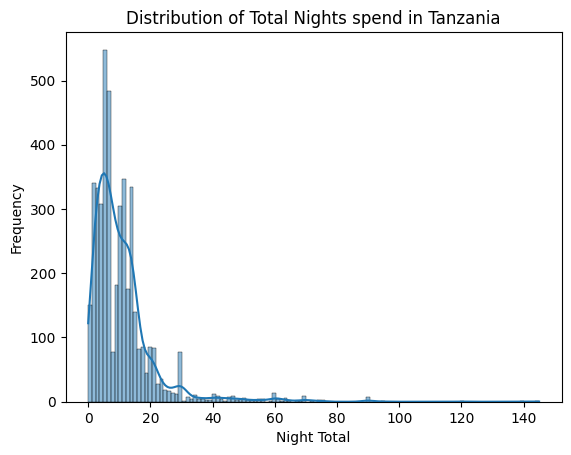

In [116]:
sns.histplot(df_train['night_total'], kde=True)
plt.title('Distribution of Total Nights spend in Tanzania')
plt.xlabel('Night Total')
plt.ylabel('Frequency')
plt.show()

## Outlier removal for very long stays

In [117]:
df_train['night_total'].value_counts().head(10)

night_total
7     484
2     340
14    334
3     333
4     308
10    304
6     283
5     265
12    203
9     182
Name: count, dtype: int64

In [118]:
df_train = remove_outliers(df_train, 'night_total', 10, 91)

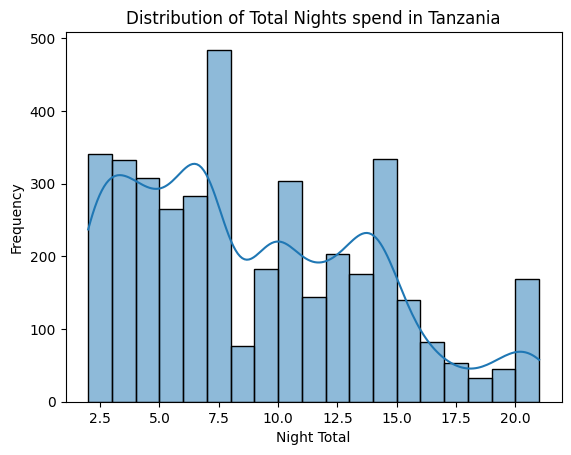

In [119]:
sns.histplot(df_train['night_total'], kde=True)
plt.title('Distribution of Total Nights spend in Tanzania')
plt.xlabel('Night Total')
plt.ylabel('Frequency')
plt.show()

In [120]:
# Spikes: 7 Days, 10 Days, 14 Days, (21 Days)

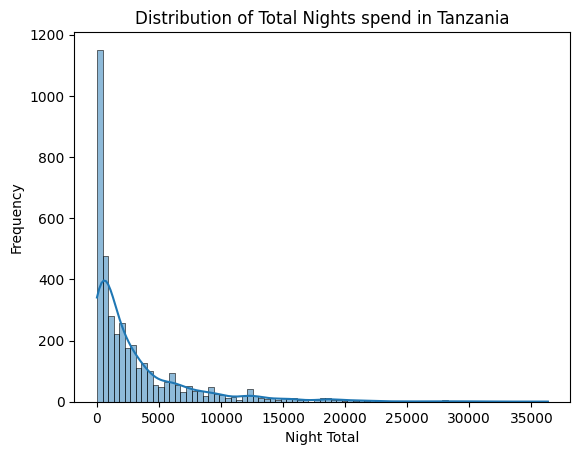

In [121]:
sns.histplot(df_train['total_cost_euro'], kde=True)
plt.title('Distribution of Total Nights spend in Tanzania')
plt.xlabel('Night Total')
plt.ylabel('Frequency')
plt.show()


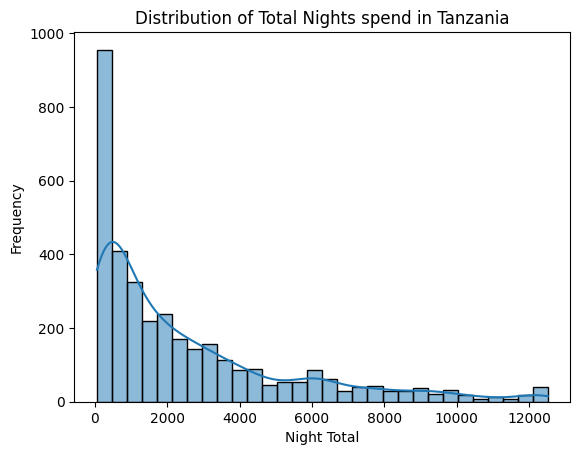

In [122]:
df_train2 = remove_outliers(df_train, 'total_cost_euro', 5, 95)
sns.histplot(df_train2['total_cost_euro'], kde=True)
plt.title('Distribution of Total Nights spend in Tanzania')
plt.xlabel('Night Total')
plt.ylabel('Frequency')
plt.show()

## Unique values of categorial columns

In [123]:
categories = ['most_impressing', 'purpose', 'main_activity', 'info_source', 'tour_arrangement', 'payment_mode']

for cat in categories:
    print('-'*80)
    print(f"[Category: {cat}] - [Null: {df_train[cat].isna().sum()}]\n")
    print(df_train[cat].value_counts())

--------------------------------------------------------------------------------
[Category: most_impressing] - [Null: 0]

most_impressing
Friendly People                         1343
Wildlife                                 963
No comments                              618
Wonderful Country, Landscape, Nature     451
Good service                             317
Excellent Experience                     233
Satisfies and Hope Come Back              29
Name: count, dtype: int64
--------------------------------------------------------------------------------
[Category: purpose] - [Null: 0]

purpose
Leisure and Holidays              2578
Business                           465
Visiting Friends and Relatives     445
Meetings and Conference            252
Other                               81
Volunteering                        72
Scientific and Academic             61
Name: count, dtype: int64
--------------------------------------------------------------------------------
[Category: main_act

## Save cleaned dataset to file

In [124]:
df_train.to_csv('data/Train_cleaned.csv', index=False)